In [30]:
import sys
import os

# Add the parent directory of `notebook/` to sys.path
sys.path.append(os.path.abspath(".."))

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
palette = ['#43AA8B', '#F8961E', '#F94144']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from scipy.interpolate import interp1d
import math


# utilities
import time
from mendeleev import element
from tqdm import tqdm
from utils.utils_data import (load_data, train_valid_test_split, plot_example, plot_predictions, weighted_mean, r2_score, save_or_load_onehot, build_data)
from utils.utils_model import Network, visualize_layers, train, evaluate
import e3nn.o3 as o3
from e3nn.util.jit import compile_mode
from e3nn.io import CartesianTensor
from e3nn.o3 import wigner_D, so3_generators
# from utils.dielectric_utils import cart2realsphvec

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Create a colormap based on the number of unique symbols
datasets = ['g', 'y', 'r']
colors = dict(zip(datasets, palette))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])
mpl.rcParams['font.family'] = 'Arial'
font_size = 20  # or whatever size you want globally

mpl.rcParams.update({
    "font.size": font_size,           # Universal font size
    "axes.titlesize": font_size,       # Axes title
    "axes.labelsize": font_size,       # Axes labels
    "xtick.labelsize": font_size - 2,  # X tick labels
    "ytick.labelsize": font_size - 2,  # Y tick labels
    "legend.fontsize": font_size - 2,  # Legend text
    "figure.titlesize": font_size + 2, # Figure title
    "font.family": "Arial"             # Optional: use Arial everywhere
})

# Check device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)

## load data
data_file = 'dataset/symmetrized_permittivity_pruned.pkl'
df, species = load_data(data_file)
df = df.reset_index(drop=True)

print('data acquired')

energy_min = 0 #Unit of energy in eV
energy_max = 30 #Unit of energy in eV
nstep = 301 #Number of the energy points

new_x = np.linspace(energy_min, energy_max, nstep)
def interpolate_matrix(row, column):
    """Interpolates the full (3001, 3, 3) matrix along the energy axis."""
    matrix = row[column]  # Shape: (3001, 3, 3)
    omega = row['omega']  # Shape: (3001,)

    # Define interpolation along the first axis (energy axis)
    interp = interp1d(omega, matrix, kind='linear', axis=0, fill_value=0, bounds_error=False)

    # Apply interpolation to the new energy points
    new_matrix = interp(new_x)  # Result shape: (251, 3, 3)
    
    return new_matrix


# Apply the custom function to create a new column
df['energies_interp'] = df.apply(lambda x: new_x, axis=1)
df['real_Permittivity_Matrices_interp'] = df.apply(lambda row: interpolate_matrix(row, 'real_symmetrized_permittivity'), axis=1)
df['imag_Permittivity_Matrices_interp'] = df.apply(lambda row: interpolate_matrix(row, 'imag_symmetrized_permittivity'), axis=1)

df.sample(10)

torch device: cpu
data acquired


,folder,formula,symmetrized_structure,mp_id,bandgap,crystal_system,omega,real_Permittivity_Matrices,imag_Permittivity_Matrices,Re_00,...,Im_22,avg_re_trace,avg_im_trace,species,real_symmetrized_permittivity,imag_symmetrized_permittivity,rotation_matrices,energies_interp,real_Permittivity_Matrices_interp,imag_Permittivity_Matrices_interp
1067,/global/cfs/cdirs/m225/angush/materialProject/...,Pb4S4,"(Atom('Pb', [1.0436928319999994, 3.17287500000...",mp-21276,0.4667,orthorhombic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[8.369380073629458, -9.248237412392232e-08, ...","[[[5.193829709913059e-18, 1.8878017297944798e-...","[8.369380073629458, 8.3695758220203, 8.3701633...",...,"[2.5348971993278303e-18, 0.0020048691033980976...","[8.394819203031545, 8.395015255396077, 8.39560...","[-7.308252256837782e-18, 0.001982757743960271,...","[S, Pb]","[[[8.369380073629458, 0.0, 0.0], [0.0, 8.42323...","[[[5.193829709913059e-18, -7.703719777548943e-...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0,...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[[8.369380073629458, 0.0, 0.0], [0.0, 8.42323...","[[[5.193829709913059e-18, -7.703719777548943e-..."
198,/global/cfs/cdirs/m225/angush/materialProject/...,Te3,"(Atom('Te', [-0.5905263607809159, 1.0228216600...",mp-567313,0.5606,trigonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[12.508581323901486, 0.04924200550265009, -0...","[[[-1.842380160188899e-17, -7.970380562930807e...","[12.508581323901486, 12.50941994114416, 12.511...",...,"[-3.7917251993057025e-17, 0.009100637124666288...","[14.376721298077932, 14.377584358959105, 14.38...","[-2.460750463830361e-17, 0.008802436050211275,...",[Te],"[[[12.50220085302383, -1.734723475976807e-16, ...","[[[-1.7952630960926906e-17, -1.027162637006525...","[[[1.0, -5.8980246154805176e-18, 0.0], [0.0, 0...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[[12.50220085302383, -1.734723475976807e-16, ...","[[[-1.7952630960926906e-17, -1.027162637006525..."
582,/global/cfs/cdirs/m225/angush/materialProject/...,Cl6I2,"(Atom('I', [6.70450081016479, 7.74027737386009...",mp-1546049,1.5693,triclinic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[1.995068208517579, 0.8905127969293462, 0.50...","[[[6.1475038000275625e-18, 8.4918732232799e-18...","[1.995068208517579, 1.9950787518090818, 1.9951...",...,"[8.338972246909037e-18, 0.00013797878609222612...","[2.126017053418598, 2.126028332657453, 2.12606...","[6.814548435172017e-18, 0.00011288322436059745...","[Cl, I]","[[[1.995068208517579, 0.8905127969293462, 0.50...","[[[6.1475038000275625e-18, 8.4918732232799e-18...","[[[1.0, 6.998061419436344e-18, 3.0531490831844...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[[1.995068208517579, 0.8905127969293462, 0.50...","[[[6.1475038000275625e-18, 8.4918732232799e-18..."
495,/global/cfs/cdirs/m225/angush/materialProject/...,CdI2,"(Atom('Cd', [0.0, 0.0, 0.0], index=0), Atom('I...",mp-567259,2.4195,trigonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[2.322040288811329, 0.0008006295839580869, -...","[[[-1.3035483303049878e-17, 5.228043686461446e...","[2.322040288811329, 2.322049266587905, 2.32207...",...,"[-4.974083269533483e-18, 7.647998743785049e-05...","[2.2592295275415917, 2.259238062345639, 2.2592...","[-3.860098834930233e-18, 8.539585220804073e-05...","[I, Cd]","[[[2.3225025826664893, -3.982239815895381e-17,...","[[[-3.303106617628608e-18, 0.0, 9.629649721936...","[[[1.0, -5.1434353186689154e-17, 0.0], [0.0, 0...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[[2.3225025826664893, -3.982239815895381e-17,...","[[[-3.303106617628608e-18, 0.0, 9.629649721936..."
79,/global/cfs/cdirs/m225/angush/materialProject/...,C2,"(Atom('C', [-2.856048730848215e-17, 1.41826093...",mp-2049878,1.6210,hexagonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[11.318720928133637, -7.115851045421248, -1....","[[[6.883716473168694e-16, 2.2282346223558374e-...","[11.318720928133637, 11.327598994253893, 11.35...",...,"[8

In [31]:
df["real_Permittivity_Matrices_interp"].iloc[0].shape

(301, 3, 3)

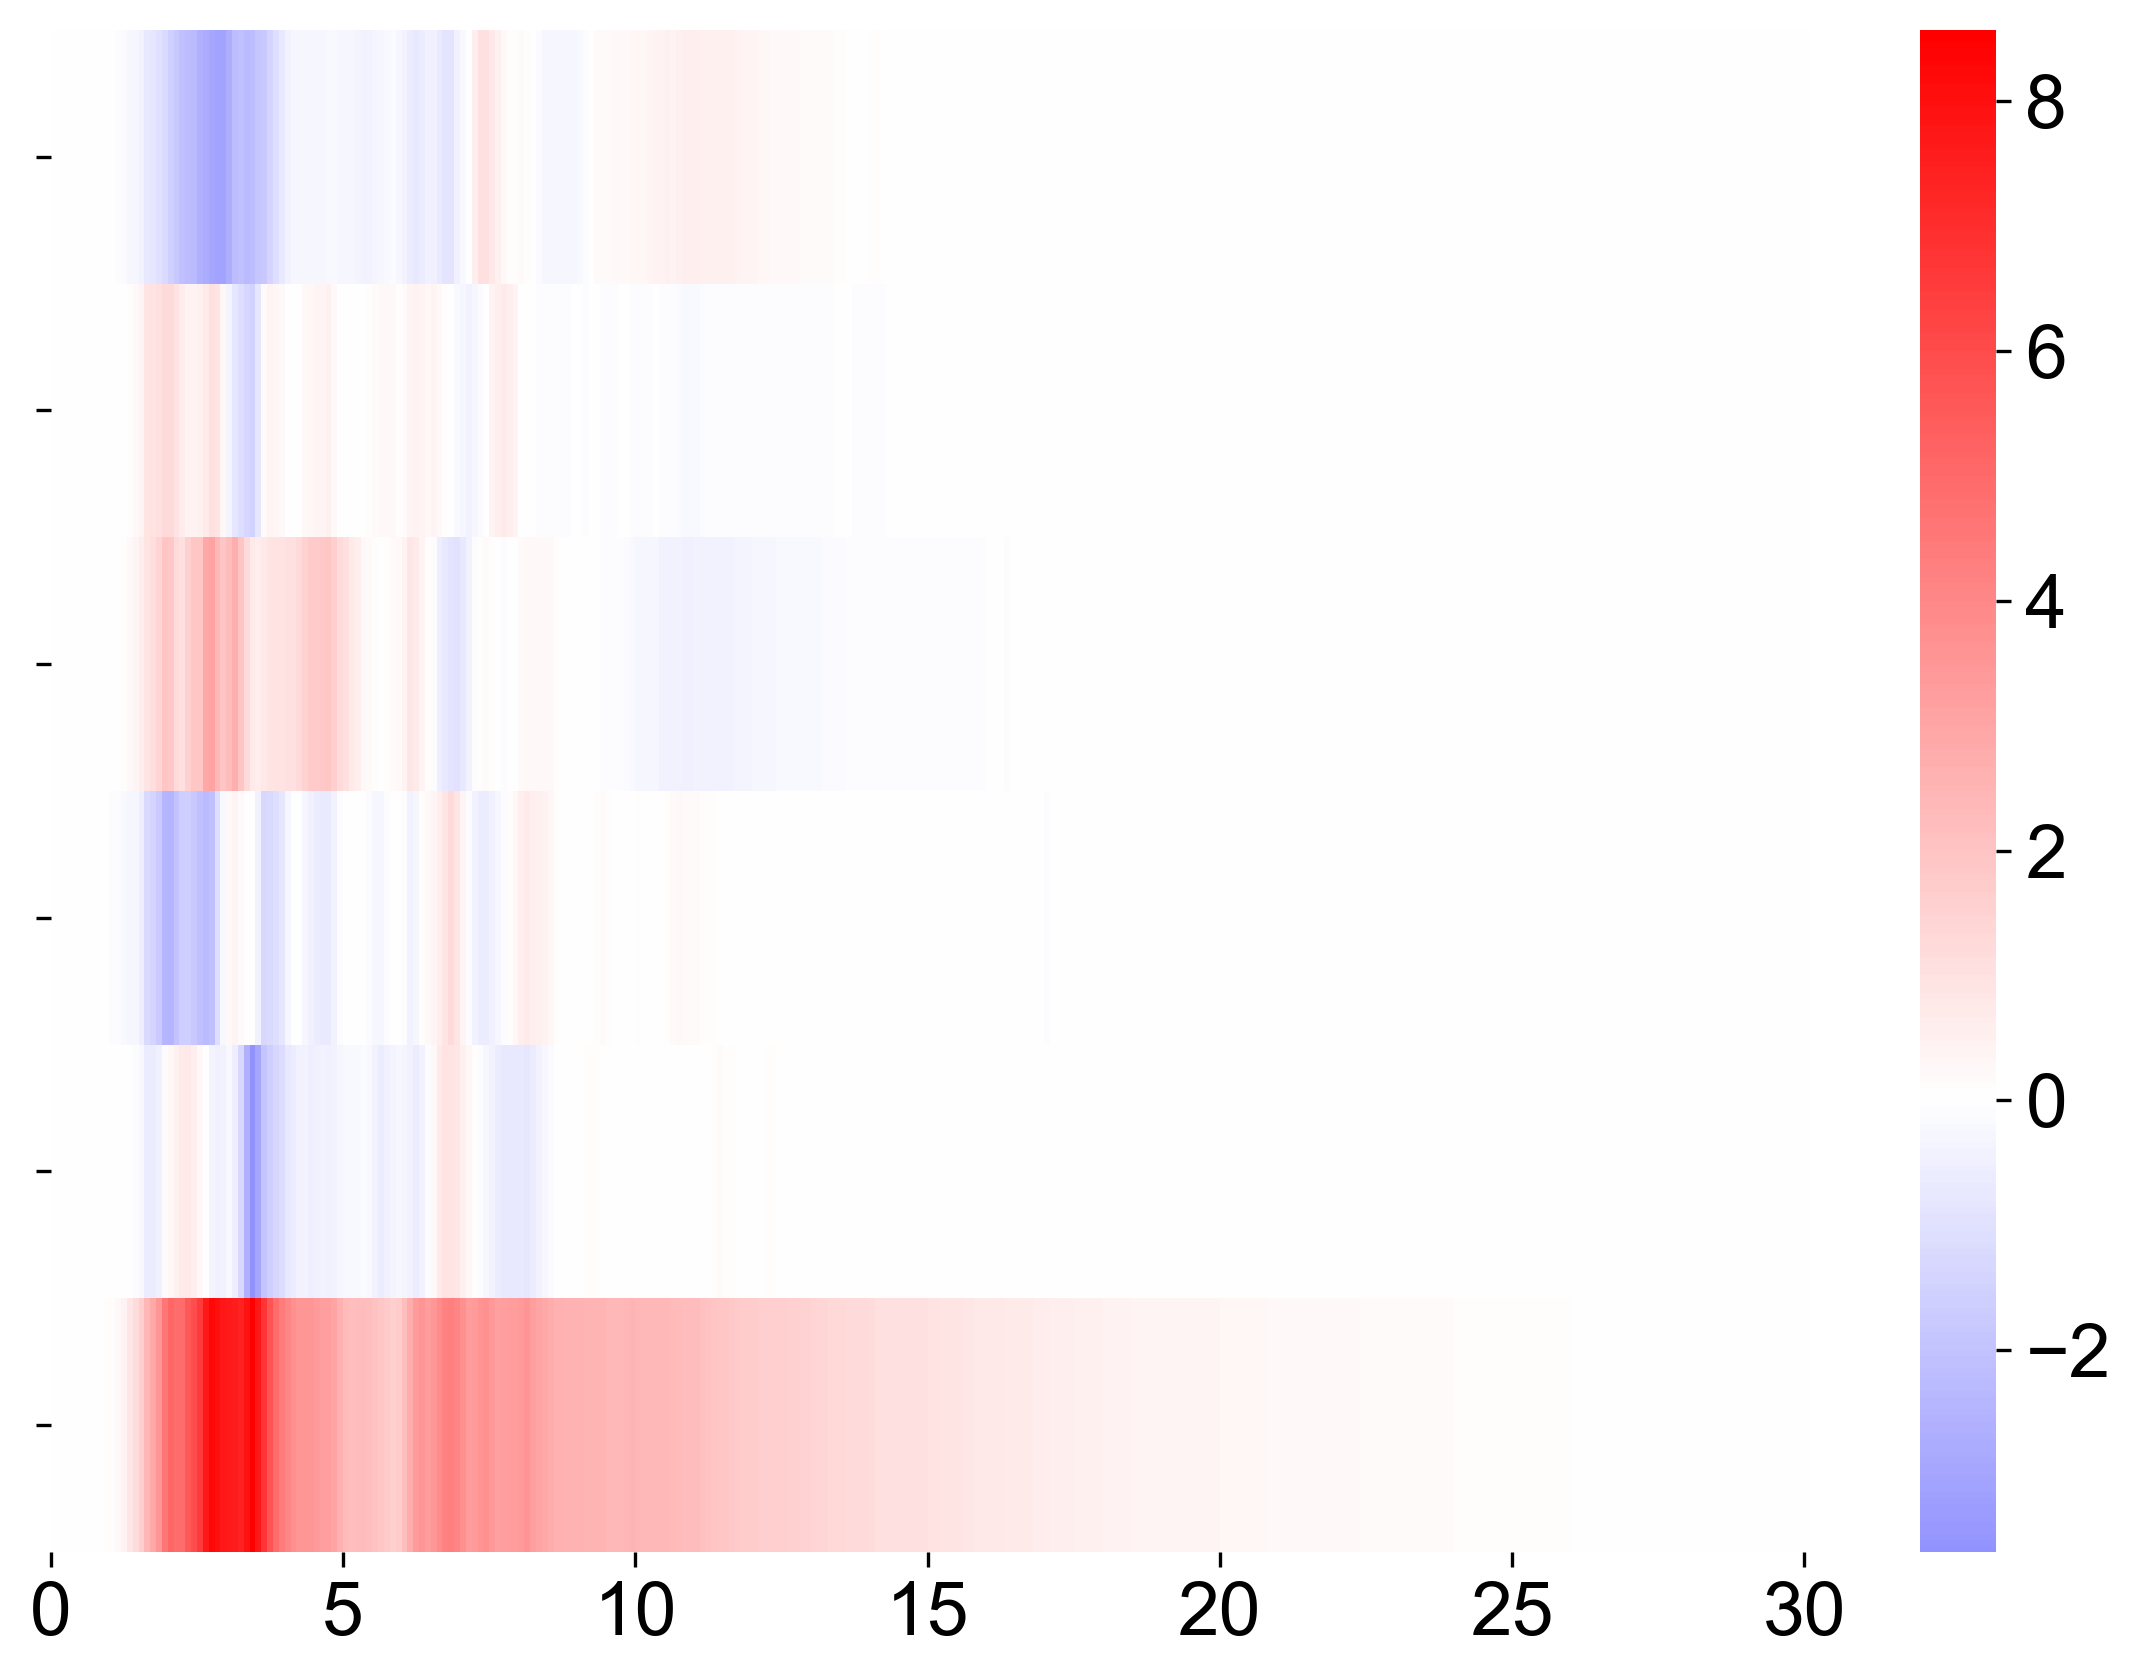

In [32]:
# Set default dtype globally
torch.set_default_dtype(torch.float64)

N_samples = 1
# sampled_df = df.sample(n=N_samples)  # Fix seed for reproducibility
# selected_df = df[df["mp_id"] == "mp-996969"] # monoclinic
# selected_df = df[df["mp_id"] == "mp-766"] # orthorhombic
# selected_df = df[df["mp_id"] == "mp-29678"] # trigonal
# selected_df = df[df["mp_id"] == "mp-441"] # cubic
# selected_df = df[df["mp_id"] == "mp-10616"] # tetragonal
# selected_df = df[df["mp_id"] == "mp-10616"] # hexagonal
selected_df = df[df["mp_id"] == "mp-2422143"] # triclinic
# selected_df = df[df["mp_id"] == "mp-1077942"] # 


# Load the dataset
permittivity = torch.tensor(selected_df["imag_Permittivity_Matrices_interp"].iloc[0], dtype=torch.float64)  # Shape (251, 3, 3)
omega = selected_df["energies_interp"].iloc[0]  # Shape (251,)
perm = torch.tensor([1, 2, 0])  # Permutation: x->2, y->0, z->1

# Permute both row and column indices in one line
permittivity_perm = permittivity.index_select(1, perm).index_select(2, perm)

# Transform Cartesian tensor to irreps
x = CartesianTensor("ij=ji")  # Symmetric rank-2 tensor
X_irrep = x.from_cartesian(permittivity_perm)  # Converts (251, 3, 3) -> (251, 6)

# **Transpose the data** so that omega is on the x-axis
X_irrep_transposed = X_irrep.T.numpy()  # Now shape (6, 251)

# Define component labels (REVERSED to put Y^0_0 at the bottom)
component_ticks = [r"$Y^2_2$", r"$Y^2_{1}$", r"$Y^2_0$", r"$Y^2_{-1}$", r"$Y^2_{-2}$", r"$Y^0_0$"]
component_ticks = [r"", r"", r"", r"", r"", r""]

# component_ticks = [r"$Y^2_0$", r"$Y^2_{-1}$", r"$Y^2_1$", r"$Y^2_{-2}$", r"$Y^2_2$"]

# Reverse the data to match the new order
X_irrep_transposed = X_irrep_transposed[::-1, :]

plt.figure(figsize=(8,6), dpi=300)
ax = sns.heatmap(
    X_irrep_transposed, 
    cmap='bwr', 
    center=0, 
    yticklabels=component_ticks, 
    xticklabels=50,
    linecolor='white',
    linewidths=0,
    cbar=True  # Keep colorbar (or cbar=False if you want to hide it)
)

# Remove the axis frames (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Set custom x-ticks
num_omega = len(omega)
tick_indices = np.linspace(0, num_omega - 1, 7, dtype=int)
tick_labels = [int(round(omega[idx])) for idx in tick_indices]

ax.set_xticks(tick_indices)
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(component_ticks, rotation=0, va="center")

plt.tight_layout()
plt.savefig("plot2_sph.pdf", bbox_inches='tight', pad_inches=0.05)
plt.show()


AsBaLi, hexagonal


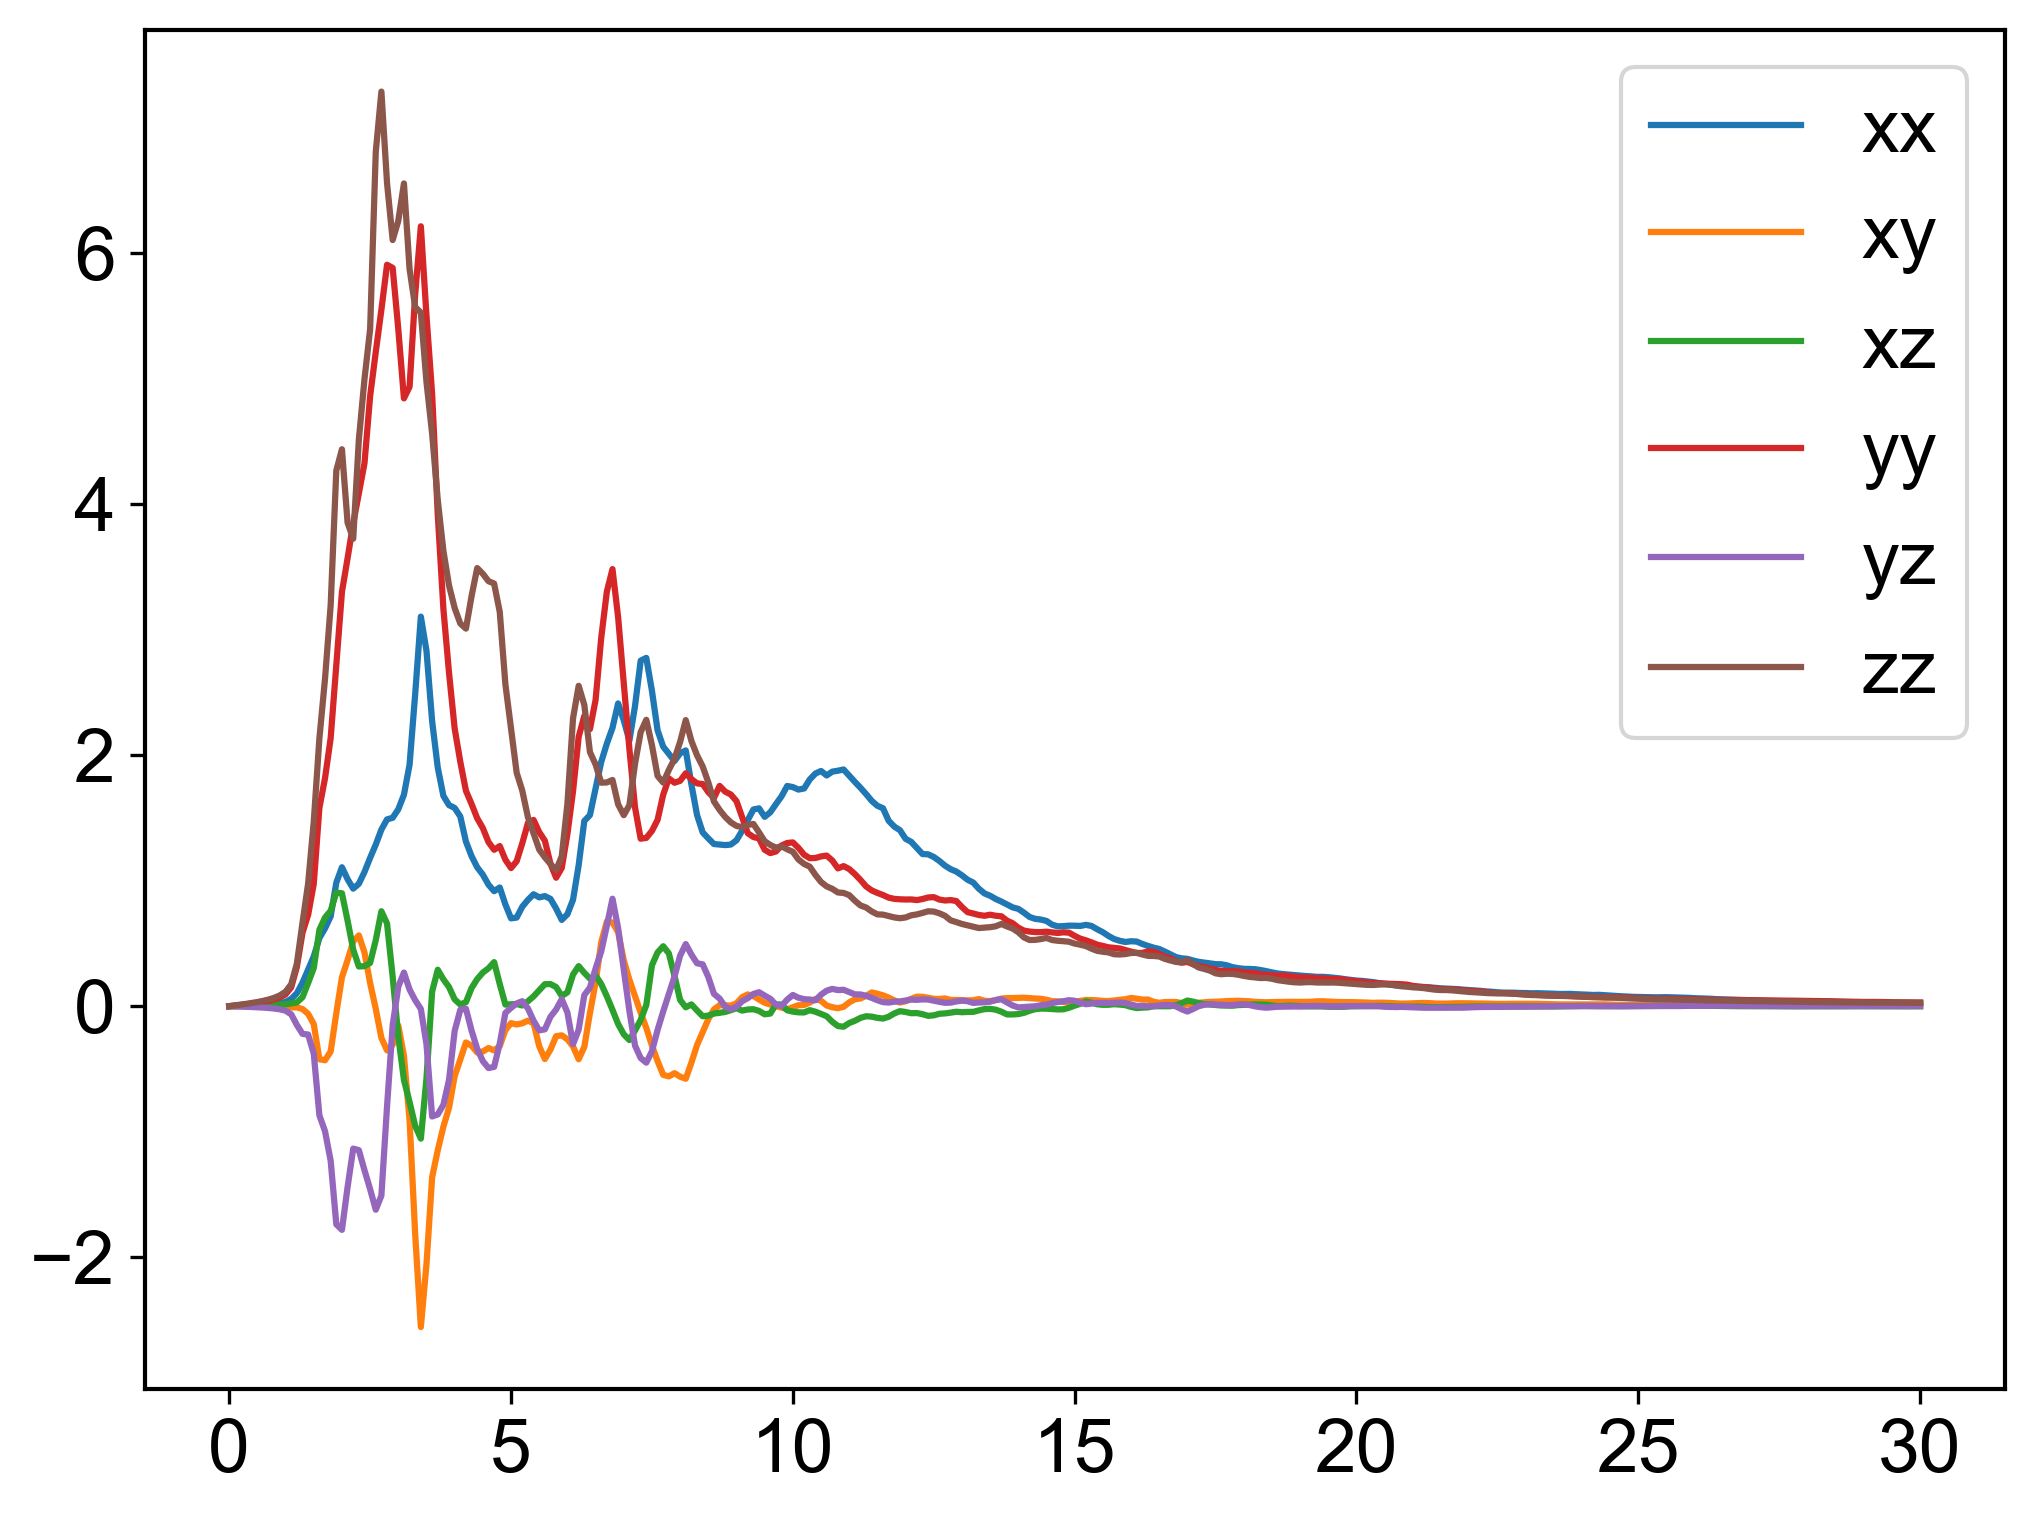

In [ ]:
test_transforamtion = x.to_cartesian(X_irrep)
inv_perm = torch.tensor([2, 0, 1])

# Permute back the row indices (dimension 1)
test_transforamtion_restored = test_transforamtion.index_select(1, inv_perm)
# Permute back the column indices (dimension 2)
test_transforamtion_restored = test_transforamtion_restored.index_select(2, inv_perm)

xyz_list = ['x', 'y', 'z']
color_map = {
    'xx': '#1f77b4',  # Blue
    'xy': '#ff7f0e',  # Orange
    'xz': '#2ca02c',  # Green
    'yy': '#d62728',  # Red
    'yz': '#9467bd',  # Purple
    'zz': '#8c564b'   # Brown
}
plt.figure(figsize=(8, 6),dpi=300)  # Set figure size for clarity

for i in range(3):
    for j in range(i, 3):
        component = f"{xyz_list[i]}{xyz_list[j]}"
        plt.plot(omega, test_transforamtion_restored[:, i, j], label=rf"${{{xyz_list[i]}{xyz_list[j]}}}$", color=color_map[component])
        
        
selected_df = df[df["mp_id"] == "mp-10616"].iloc[0] # 
    
print(f"{selected_df.formula}, {selected_df.crystal_system}")
# plt.title(f"{selected_df.formula}, {selected_df.crystal_system}")
# Add legend, labels, and title
plt.legend()
plt.savefig("plot2_cart.pdf", bbox_inches='tight', pad_inches=0.05)
plt.show()


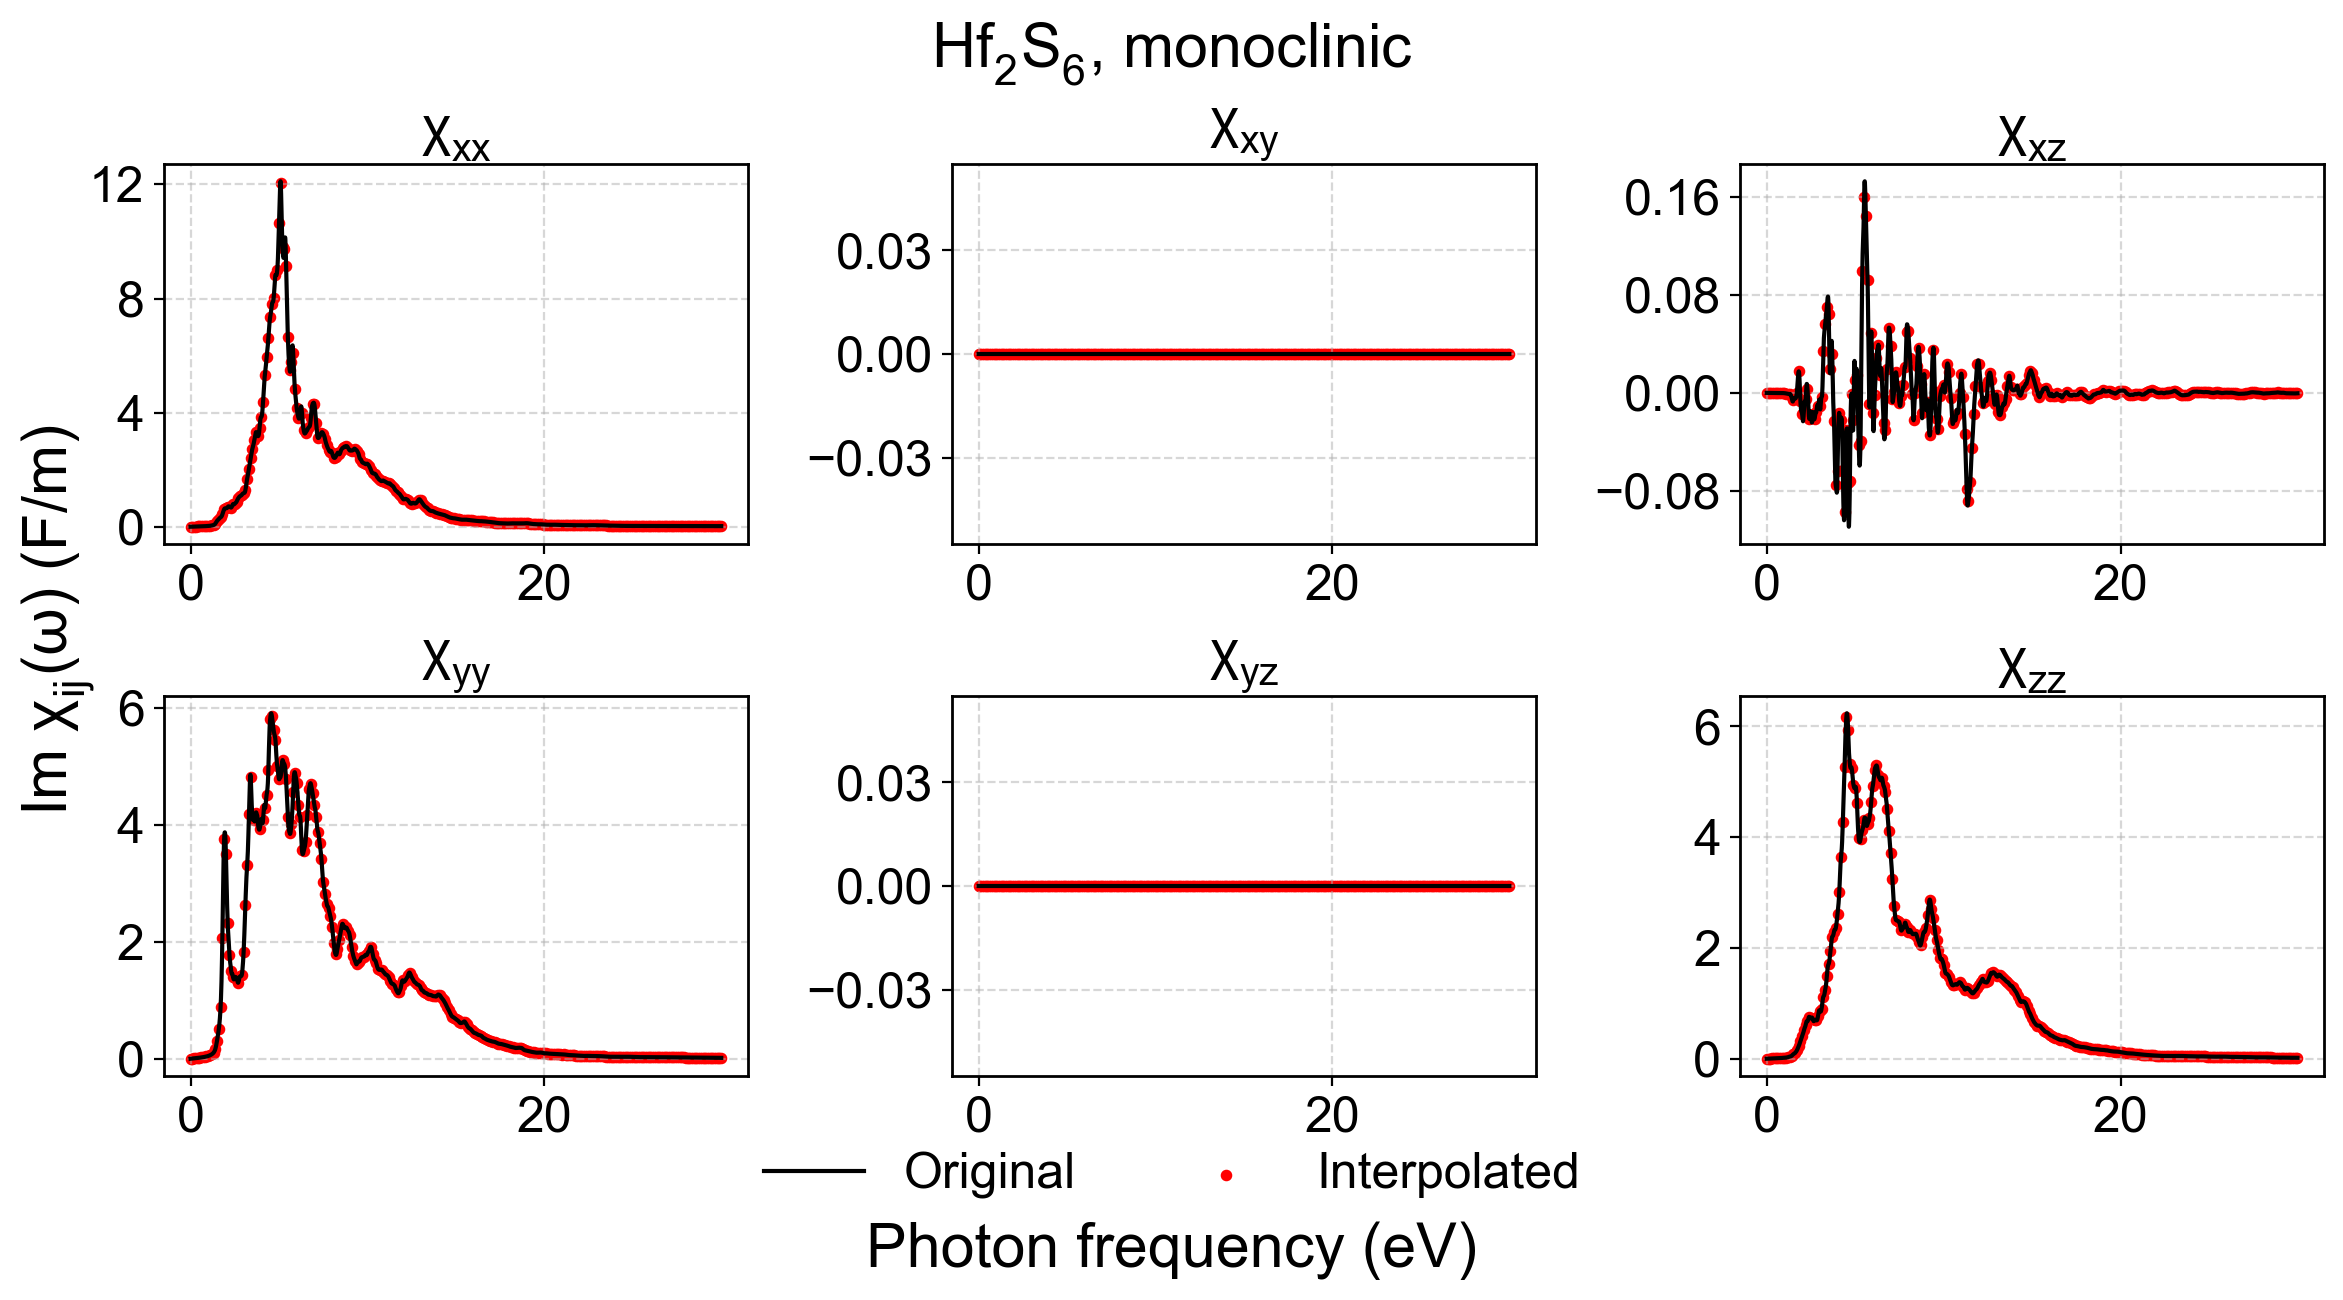

In [34]:
# Retrieve corresponding real data (interpolated)
from matplotlib.ticker import MaxNLocator

def format_chemical_formula(formula):
    if not formula:
        return formula
    result = ''
    i = 0
    while i < len(formula):
        char = formula[i]
        if char.isalpha():
            element = char
            i += 1
            if i < len(formula) and formula[i].islower():
                element += formula[i]
                i += 1
            result += element
            number = ''
            while i < len(formula) and formula[i].isdigit():
                number += formula[i]
                i += 1
            if number:
                result += f'_{{{number}}}'
            if i < len(formula) and formula[i] == '^':
                i += 1
                superscript = ''
                while i < len(formula) and (formula[i].isdigit() or formula[i] in ['+', '-']):
                    superscript += formula[i]
                    i += 1
                if superscript:
                    result += f'^{{{superscript}}}'
        else:
            result += char
            i += 1
    return result

selected_df = df[df["mp_id"] == "mp-9922"].iloc[0]
omega_interp = selected_df["energies_interp"]
omega = selected_df["omega"]
formula = selected_df["formula"]

crystal_system = selected_df["crystal_system"]

# Labels and component order
xyz_list = ['x', 'y', 'z']
components = [(i, j) for i in range(3) for j in range(i, 3)]  # xx, xy, xz, yy, yz, zz
fig, axes = plt.subplots(2, 3, figsize=(12, 6), dpi=200)  # Wider and a bit taller
axes = axes.ravel()

for k, (i, j) in enumerate(components):
    ax = axes[k]
    component = f"{xyz_list[i]}{xyz_list[j]}"
    
    ax.plot(omega, selected_df.imag_symmetrized_permittivity[:, i, j], label="Original", color="black")
    ax.scatter(omega_interp, selected_df.imag_Permittivity_Matrices_interp[:, i, j], label="Interpolated", color="red", s=10)
    
    ax.set_title(rf"$\chi_{{{component}}}$")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))

# Shared legend below all subplots
handles, labels = axes[0].get_legend_handles_labels()
# Add legend slightly above the bottom
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=2, frameon=False)

# Global labels and title
formatted_formula = format_chemical_formula(formula)
fig.suptitle(rf"${formatted_formula}$, {crystal_system}", y=1.0)
fig.supylabel(r"Im $\chi_{{ij}}(\omega)$ (F/m)", x=0.02)
fig.supxlabel(r"Photon frequency (eV)", y=-0.05)  # Lowered further
plt.subplots_adjust(left=0.08, right=0.98, top=0.88, bottom=0.12, wspace=0.35, hspace=0.4)
plt.show()


In [35]:
## load data
data_file = '../dataset/symmetrized_permittivity.pkl'
df, species = load_data(data_file)
df = df.reset_index(drop=True)

print('data acquired')



energy_min = 0 #Unit of energy in eV
energy_max = 20 #Unit of energy in eV
nstep = 201 #Number of the energy points

new_x = np.linspace(energy_min, energy_max, nstep)
# Efficiently interpolate all matrices using list comprehension
def interpolate_matrix(matrix, omega):
    """Interpolates the full (3001, 3, 3) matrix along the energy axis."""
    interp = interp1d(omega, matrix, kind='linear', axis=0, fill_value=0, bounds_error=False)
    return interp(new_x)  # Shape: (201, 3, 3)


# Apply interpolation efficiently
df['real_Permittivity_Matrices_interp'] = [
    interpolate_matrix(row['real_Permittivity_Matrices'], row['omega']) for _, row in df.iterrows()
]

# Apply the custom function to create a new column
df['energies_interp'] = df.apply(lambda x: new_x, axis=1)

perm_matrices_tensor = torch.tensor(np.stack(df['real_Permittivity_Matrices_interp'].values), dtype=torch.float64, device=device)

# Transform Cartesian tensor to irreps
x = CartesianTensor("ij=ji")  # Symmetric rank-2 tensor
sph_coefs_tensor = x.from_cartesian(perm_matrices_tensor)  # Shape: (num_samples, 201, 6)

df['sph_coefs'] = list(sph_coefs_tensor.cpu().numpy())  # Move to CPU and store as list

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/symmetrized_permittivity.pkl'

In [ ]:
df.head()

,folder,formula,symmetrized_structure,mp_id,bandgap,crystal_system,omega,real_Permittivity_Matrices,imag_Permittivity_Matrices,Re_00,...,Im_22,avg_re_trace,avg_im_trace,real_symmetrized_permittivity,imag_symmetrized_permittivity,rotation_matrices,species,real_Permittivity_Matrices_interp,energies_interp,sph_coefs
0,/global/cfs/cdirs/m225/angush/materialProject/...,Li4Se8Y4,"(Atom('Li', [2.8385500000000006, 0.0, 2.88335]...",mp-37879,1.6604,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.481281668892605, -1.3506806366681457e-09,...","[[[-1.0722568410351282e-17, -2.371619162135055...","[3.481281668892605, 3.4813019889159484, 3.4813...",...,"[3.342549740214423e-18, 0.0001803350567406132,...","[3.4405690641171667, 3.44058861685612, 3.44064...","[-7.234861265325764e-18, 0.0001957028760583553...","[[[3.4812758467294405, 0.0, -2.584939414228211...","[[[-1.2523566768095863e-17, 0.0, -4.8148248609...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0,...","[Se, Li, Y]","[[[3.481281668892605, -1.3506806366681457e-09,...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[5.959240426000634, 2.1550556755599532e-08, -..."
1,/global/cfs/cdirs/m225/angush/materialProject/...,Mo3S2Se4,"(Atom('Mo', [1.6365999999999998, 0.94489145055...",mp-1025906,0.5619,trigonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[5.126763705823415, -0.0036857171285808207, ...","[[[3.2316203633511406e-17, 4.065761255667405e-...","[5.126763705823415, 5.1268254576594545, 5.1270...",...,"[5.356300432663947e-18, 0.00011878724682517897...","[4.321433518069999, 4.321478600797114, 4.32161...","[1.9282726697651513e-17, 0.0004517163617600133...","[[[5.124538605076387, 6.794333614242494e-18, 5...","[[[2.6245939830145304e-17, -2.5679065925163146...","[[[1.0, 3.969365967485894e-18, 0.0], [0.0, 1.0...","[Se, Mo, S]","[[[5.126763705823415, -0.0036857171285808207, ...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[7.484942414828355, 4.219775113713422e-05, -0..."
2,/global/cfs/cdirs/m225/angush/materialProject/...,Li3NbS4,"(Atom('Li', [0.0, 0.0, 3.0251], index=0), Atom...",mp-755309,2.8348,cubic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[1.7313146368871726, 7.054466462945285e-06, ...","[[[2.9669125906530276e-18, 2.117513176816877e-...","[1.7313146368871726, 1.7313217564659527, 1.731...",...,"[-6.4642318455671115e-18, 7.12408590969345e-05...","[1.7313150452437125, 1.7313221648231247, 1.731...","[9.731758164650026e-19, 7.124085259360446e-05,...","[[[1.7313150452437125, -3.529303946892918e-23,...","[[[9.73175816465002e-19, 0.0, 0.0], [0.0, 9.73...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0,...","[Li, S, Nb]","[[[1.7313146368871726, 7.054466462945285e-06, ...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[2.99872562227052, 9.67129677258326e-06, 9.97..."
3,/global/cfs/cdirs/m225/angush/materialProject/...,CdSe2Zn,"(Atom('Zn', [2.07525, 2.07525, 2.981], index=0...",mp-1017534,0.7236,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.2667371759234984, -3.486898178425755e-06,...","[[[-1.7162171221554744e-17, -4.972084285417574...","[3.2667371759234984, 3.266768077328808, 3.2668...",...,"[-1.5461680231046413e-17, 0.000264086382651040...","[3.270700626888884, 3.270730008788789, 3.27081...","[-1.1048250663480898e-17, 0.000294768918248031...","[[[3.2667200732203123, 0.0, 0.0], [0.0, 3.2667...","[[[-8.841535879698145e-18, 0.0, -9.62964972193...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0,...","[Se, Zn, Cd]","[[[3.2667371759234984, -3.486898178425755e-06,...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[5.665019662118925, 2.995555543900532e-05, -4..."
4,/global/cfs/cdirs/m225/angush/materialProject/...,Al8Te12,"(Atom('Al', [-1.0110162555088607, 0.7063003620...",mp-1228524,1.3222,monoclinic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.57865600493003, -2.773634699822434e-08, 0...","[[[-2.370171074423322e-18, -5.455394216331598e...","[3.57865600493003, 3.5786781470220483, 3.57874...",...

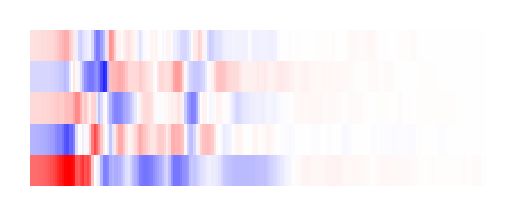

In [ ]:
selected_df = df[df["mp_id"] == "mp-2422143"]  # Example material

re_permittivity = torch.tensor(selected_df["real_Permittivity_Matrices_interp"].iloc[0], dtype=torch.float64)  # Shape (251, 3, 3)
omega = selected_df["energies_interp"].iloc[0]  # Shape (251,)

# Transform Cartesian tensor to irreps
x = CartesianTensor("ij=ji")  # Symmetric rank-2 tensor
X_irrep = x.from_cartesian(re_permittivity)  # Converts (251, 3, 3) -> (251, 6)

# Extract l=2 components only (skip l=0)
X_l2 = X_irrep[:, 1:]  # Shape: (251, 5)

# Transpose the data so that omega is on the x-axis
X_irrep_transposed = X_l2.T.numpy()  # Now shape (5, 251)

# Define component labels for l=2 only (commented out since yticklabels=False)
# component_ticks = [r"$Y^2_0$", r"$Y^2_{-1}$", r"$Y^2_1$", r"$Y^2_{-2}$", r"$Y^2_2$"]

# Plot the tiny heatmap without a colorbar
plt.figure(figsize=(2, 1), dpi=300)  # Small size to fit in MSE loss section
ax = sns.heatmap(X_irrep_transposed, cmap='bwr', center=0, yticklabels=False, xticklabels=False, cbar=False)

# Set proper axis labels (minimal for small plot, commented out as per your code)
# plt.xlabel(r"$\omega$", fontsize=8)
# plt.ylabel(r"$Y^2_m$", fontsize=8)

# Remove x-axis ticks for simplicity (already handled by xticklabels=False)

# Tight layout to minimize whitespace
plt.tight_layout()

# Optional: Save or show
# plt.savefig("l2_heatmap_tiny_no_colorbar.png", dpi=300, bbox_inches="tight")
plt.show()

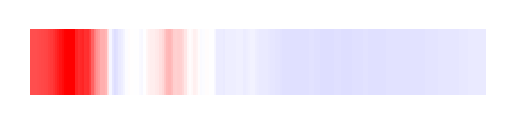

In [ ]:
# **Extract l=0 channel only**
# l=0 is the first dimension (scalar component)
X_l0 = X_irrep[:, 0]  # Shape: (251,)

# **Reshape for heatmap** (sns.heatmap expects 2D data, so make it (1, 251))
X_l0_transposed = X_l0[None, :].numpy()  # Shape: (1, 251)


# Plot the tiny heatmap without a colorbar
plt.figure(figsize=(2, 0.7), dpi=300)  # Smaller height since it's 1 row
ax = sns.heatmap(X_l0_transposed, cmap='bwr', center=0, yticklabels=False, xticklabels=False, cbar=False)

# Set proper axis labels (minimal for small plot)
# plt.xlabel(r"$\omega$", fontsize=8)  # Commented out as per your preference

# Remove x-axis ticks for simplicity (already handled by xticklabels=False)

# Tight layout to minimize whitespace
plt.tight_layout()

# Optional: Save or show
# plt.savefig("l0_heatmap_tiny_no_colorbar.png", dpi=300, bbox_inches="tight")
plt.show()